<a href="https://colab.research.google.com/github/alxtyl/118B-FinalProject/blob/main/118B_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Data Wrangling

Here, we import the speech of around 2,000 international English speakers. However, we only want the American English ones, and only roughly the first 10 seconds of speech. The goal of the data is to look like this: 

| Speaker | Speech File | Formant 1 | Formant 2 | Formant 3 | 

In [7]:
#Install dependencies and import all packages along with dataset
!pip install praat-parselmouth
!pip install -U praat-parselmouth
!pip install hmmlearn
!curl -O http://164.92.77.249/speech.tar.gz
!tar -xf speech.tar.gz

from hmmlearn import base, hmm
from mpl_toolkits import mplot3d
from parselmouth import praat
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import csv
import parselmouth
import math

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  863M  100  863M    0     0  68.8M      0  0:00:12  0:00:12 --:--:-- 70.3M


# Data Wrangling and Formant Extraction - Bridget

In [8]:
Archive_Path = "SpeechArchive/"
reading_passage = Archive_Path + "reading-passage.txt"
with open(reading_passage, "r") as file1:
    FileContent = file1.read()
FileContent

'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.\n'

Here, we are just testing to be sure we can access the mp3 file. 

In [9]:
file_name = 'english145.mp3'
example_audio = Archive_Path + '/recordings/recordings/' + file_name

x, sr = librosa.load(example_audio)
ipd.Audio(x, rate = sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Now that the audio is loaded in, we need to find the speakers that we want to analyze. Let's load it as a csv, and as a df, since I am indecisive.



In [10]:
speaker_inf = Archive_Path + "speakers_all.csv"

rows = []
with open(speaker_inf, 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
print(header)
print(rows)

['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?', '', '', '']
[['24', '12', 'koussi, senegal', 'balanta', 'balanta', 'male', '788', 'senegal', 'TRUE', '', '', ''], ['18', '10', 'buea, cameroon', 'cameroon', 'cameroon', 'male', '1953', 'cameroon', 'TRUE', '', '', ''], ['48', '8', 'hong, adamawa, nigeria', 'fulfulde', 'fulfulde', 'male', '1037', 'nigeria', 'TRUE', '', '', ''], ['42', '42', 'port-au-prince, haiti', 'haitian', 'haitian', 'male', '1165', 'haiti', 'TRUE', '', '', ''], ['40', '35', 'port-au-prince, haiti', 'haitian', 'haitian', 'male', '1166', 'haiti', 'TRUE', '', '', ''], ['43', '41', 'port-au-prince, haiti', 'haitian', 'haitian', 'male', '1167', 'haiti', 'TRUE', '', '', ''], ['21', '21', 'port-au-prince, haiti', 'haitian', 'haitian', 'male', '1168', 'haiti', 'TRUE', '', '', ''], ['54', '51', 'port-au-prince, haiti', 'haitian', 'haitian', 'female', '1169', 'haiti', 'TRUE', '', '', ''], ['18', '16', 'ouanaminthe,

In [11]:
speaker_df = pd.read_csv(speaker_inf)

As is the goal of the dataset, we just want native English speakers. (Only from America? I think having all the native speakers would be cool. )

In [12]:
# native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english'])) & (speaker_df['country'].isin(['usa']))]
native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english']))]
#weird unnamed columns b/c weird zip csv file?? dropt. periodt.
native_english_speakers = native_english_speakers.drop(['Unnamed: 9',	'Unnamed: 10',	'Unnamed: 11'], axis=1)


#strangely, this dataset only output 40 formants, not useful for comparison english 145, english317, english315, english450
native_english_speakers[348:398]
native_english_speakers = native_english_speakers.drop([414,603,605,753])
native_english_speakers = native_english_speakers.reset_index()
# native_english_speakers[210:250]


#drop english145

native_english_speakers.shape

(575, 10)

And now we have the names for all the files: 

In [13]:
native_english_files = native_english_speakers['filename']
native_english_files.shape

(575,)

So now we are able to begin feature extraction for the relevant audio files, which will be the first three formants. 

In [46]:
example_aud = Archive_Path + 'recordings/recordings/english1.mp3'
print(example_aud)

SpeechArchive/recordings/recordings/english1.mp3


In [14]:
# ala http://blog.syntheticspeech.de/2021/03/10/how-to-extract-formant-tracks-with-praat-and-python/
def acquire_formants(file_path):
  f1_list = []
  f2_list = []
  f3_list = []

  f0min = 75
  f0max = 300
  time_limit = 15

  sound = parselmouth.Sound(file_path) 
  sound = parselmouth.Sound.extract_part(sound, 0, time_limit)
  pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)

  formants = praat.call(sound, "To Formant (burg)", 0.005, 5, 5500, 0.025, 50)
  numPoints = praat.call(pointProcess, "Get number of points")
  #How is the number of points determined? Is there a way to make it proportional
  #to the number of samples?
  # print("Samples: " + str(sound.n_samples))
  # print("Num: " + str(numPoints))

  for point in range(0, numPoints):
      point += 1
      t = praat.call(pointProcess, "Get time from index", point)
      f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
      f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
      f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
      f1_list.append(f1)
      f2_list.append(f2)
      f3_list.append(f3)
    
  # print(f1_list)
  return f1_list, f2_list, f3_list
 

In [ ]:
# acquire_formants(Archive_Path + 'recordings/recordings/' + 'english145.mp3')

In [15]:
def add_formants(native_english_files, df):
  
  f1, f2, f3 = [],[],[]
  count = 0 
  file_count = len(native_english_files) 

  min_len = 10000
  for speaker_file in native_english_files: 
    
    file_path = Archive_Path + 'recordings/recordings/' + speaker_file + '.mp3'
    
    formants = acquire_formants(file_path)
    count += 1
    print(speaker_file, "done.", count, "of", file_count, "complete!")
    
    f1.append(formants[0])
    f2.append(formants[1])
    f3.append(formants[2])

    len_f1, len_f2, len_f3 = len(formants[0]), len(formants[1]), len(formants[2])

    speaker_min = min(len_f1, len_f2, len_f3)

    if speaker_min < min_len: 
      min_len = speaker_min 
      print("min_len update:", speaker_file, ":", min_len)

  for i in range(len(f1)): 
    min_len = min_len
    f1[i] = f1[i][:min_len]
    f2[i] = f2[i][:min_len]
    f3[i] = f3[i][:min_len]

  for speaker_file in native_english_files: 
    df['f1'] = f1
    df['f2'] = f2
    df['f3'] = f3

  return df

#test: 
nes_first_3 = native_english_speakers.head(3)
# native_english_files[:3]
test_3 = add_formants(native_english_files[:3], nes_first_3)

english1 done. 1 of 3 complete!
min_len update: english1 : 592
english10 done. 2 of 3 complete!
english100 done. 3 of 3 complete!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [16]:
test_3['f1'].str.len()

0    592
1    592
2    592
Name: f1, dtype: int64

In [47]:
# run to regen nes
# native_english_speakers = add_formants(native_english_files, native_english_speakers)

Grab the pickle files off the server

In [17]:
!curl -O http://164.92.77.249/native_english.pck
!curl -O http://164.92.77.249/native_english_clipped394.pck

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  22.0M      0 --:--:-- --:--:-- --:--:-- 22.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6028k  100 6028k    0     0  14.2M      0 --:--:-- --:--:-- --:--:-- 14.1M


In [18]:
#native_english_speakers = pd.read_pickle("/content/drive/MyDrive/native_english.pck")
native_english_speakers = pd.read_pickle("native_english.pck")

#native_english_speakers_clip = pd.read_pickle("/content/drive/MyDrive/native_english_clipped394.pck")
native_english_speakers_clip = pd.read_pickle("native_english_clipped394.pck")

native_english_speakers.shape

(579, 12)

In [19]:
native_english_speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.21766592628603, 383.3048603159792, 375.73...","[2146.197420848668, 2265.073676608922, 2238.96...","[2526.155130504279, 2580.1540708955213, 2610.8..."
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.791572791465, 333.5406503005196, 358.1649...","[1974.9033700266357, 2084.588564208539, 2124.4...","[2853.4023216197447, 2889.707512237676, 2857.9..."
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[313.11571323002556, 293.7516378968984, 291.04...","[837.2749761154321, 998.0551739573779, 1028.83...","[1309.0288192622993, 1290.5245752384428, 1285...."
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3027180808342, 402.10113594759747, 443.54...","[1610.8220469527037, 1729.9302654331407, 1802....","[2926.824953545606, 3045.423389665372, 3216.60..."
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.16943505125215, 396.30873727164476, 387.7...","[1172.411118682909, 1237.7783779601746, 1354.2...","[2986.2940891488297, 2949.1760833289895, 2712...."


In [20]:
native_english_speakers['f1'].str.len()

363    374
364    765
365    862
366    915
367    612
      ... 
937    577
938    479
939    313
940    611
941    992
Name: f1, Length: 579, dtype: int64

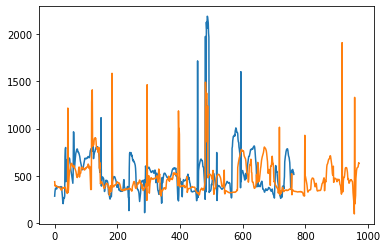

In [27]:
speak364 = np.array(native_english_speakers.at[364, 'f1'])
speak500 = np.array(native_english_speakers.at[500, 'f1'])
plt.plot(speak364)
plt.plot(speak500)

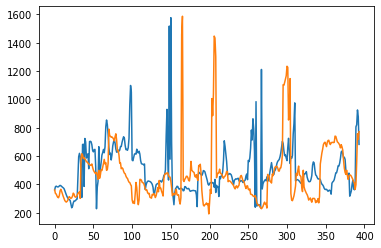

In [28]:
speak364_clip = np.array(native_english_speakers_clip.at[364, 'f1'])
speak500_clip = np.array(native_english_speakers_clip.at[500, 'f1'])
plt.plot(speak364_clip)
plt.plot(speak500_clip)

# Cross-Correlation - Donovan

Ideal shift for alignment:
49


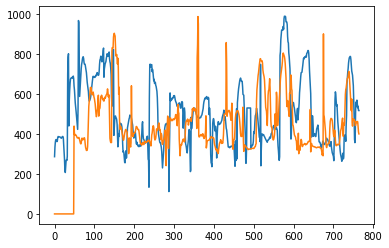

In [29]:
#Just some correlation testing
def patch_invalid(x, limit):
  for i in range(1, len(x)):
    if x[i] > limit or math.isnan(x[i]):
      x[i] = x[i-1]
  return x

def cross_corr(file_a, file_b):
  #largest allowed offset to shift the datapoints
  MAX_SHIFT = 50
  #maximum frequency before patching with n-1 datapoint
  PATCH_MAX = 1000
  interp_domain = np.linspace(0, len(file_b), len(file_a))
  stretch = np.interp(interp_domain, np.arange(0, len(file_b)), patch_invalid(file_b, 1000))
  dat1 = patch_invalid(file_a, PATCH_MAX)  
  dat2 = stretch
  dat1_m = dat1 - np.mean(dat1)
  dat2_m = dat2 - np.mean(dat2)
  print("Ideal shift for alignment:")
  min_index = len(dat1) - MAX_SHIFT
  max_index = len(dat1) + MAX_SHIFT
  #find the maximum correlation from within (-MAX_SHIFT, +MAX_SHIFT)
  ideal = np.argmax(np.correlate(dat1_m, dat2_m, mode='full')[min_index:max_index]) - MAX_SHIFT
  print(ideal)
  dat2 = np.roll(dat2, ideal)
  if ideal > 0:
    dat2[0:ideal] = 0
  else:
    dat2[-ideal:-1] = 0

  plt.plot(dat1)
  plt.plot(dat2)

cross_corr(speak364, speak500)

Ideal shift for alignment:
6


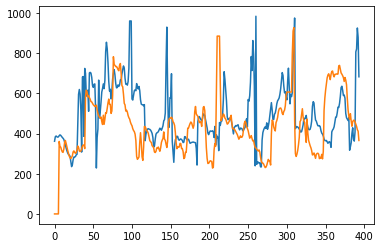

In [30]:
cross_corr(speak364_clip, speak500_clip) 

In [31]:
mean_data = pd.DataFrame(columns=['f1', 'f2', 'f3'])

for idx, rows in native_english_speakers.iterrows():
  f_1 = [x for x in rows['f1'] if np.isnan(x) == False]
 
  f_2 = [y for y in rows['f2'] if np.isnan(y) == False]
  
  f_3 = [z for z in rows['f3'] if np.isnan(z) == False]
  
  
  mean_1 = np.mean(f_1)
  #print(mean_1)
  mean_2 = np.mean(f_2)
  #print(mean_2)
  mean_3 = np.mean(f_3)
  #print(mean_3)
  mean_data.at[idx, 'f1'] = mean_1
  mean_data.at[idx, 'f2'] = mean_2
  mean_data.at[idx, 'f3'] = mean_3  

In [32]:
mean_data.shape

(579, 3)

In [33]:
#getting rid some of the outliers
f12_df = mean_data[['f1', 'f2']]

In [34]:
f12_df = f12_df[(f12_df['f1'] <= 1250) & (f12_df['f2'] <= 2350)]
f12_df.max()

f1    1248.410638
f2    2276.193613
dtype: object

In [35]:
mean_data.head()

,f1,f2,f3
363,547.496854,1708.859646,2663.916543
364,530.511878,1803.938875,2750.757498
365,384.03308,1692.323742,2972.540686
366,497.698778,1889.913689,2955.618529
367,448.085294,1464.683065,2646.339135


Gonna visualize the f1, f2, and f3

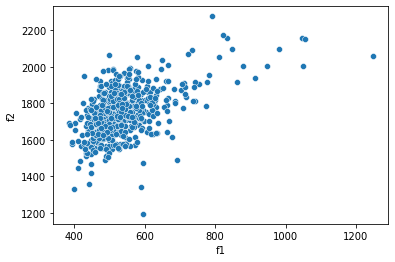

In [36]:
# F1 and F2
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df)

In [37]:
f12_df.shape

(575, 2)

# PCA - Donovan


(575, 1182)


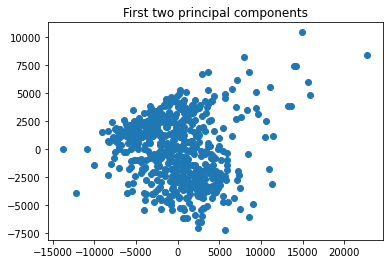

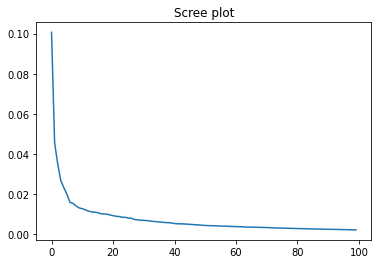

In [38]:
#wrangling nonsense to get dataframe into a numpy array
#each formant is concatenated together into the same column
selectf1 = native_english_speakers_clip[['f1']]
selectf2 = native_english_speakers_clip[['f2']]
selectf3 = native_english_speakers_clip[['f3']]
npself1 = selectf1.to_numpy().reshape((len(selectf1),))
npself1_2d = np.array(list(npself1))
npself2 = selectf2.to_numpy().reshape((len(selectf2),))
npself2_2d = np.array(list(npself2))
npself3 = selectf3.to_numpy().reshape((len(selectf3),))
npself3_2d = np.array(list(npself3))
total_np_data = np.concatenate((npself1_2d, npself2_2d, npself3_2d), axis=1)

#remove a handful of nan/inf
total_np_data[~np.isfinite(total_np_data)] = 0
print(total_np_data.shape)


pca_var = PCA(n_components=100)
pca_df = pca_var.fit_transform(total_np_data)
plt.title("First two principal components")
plt.scatter(pca_df[:,0], pca_df[:,1])
plt.figure()
plt.title("Scree plot")
plt.plot(pca_var.explained_variance_ratio_)

#TODO: Use regions for coloring points in the plot, see if there is some structure

# K-Means - Aryaman


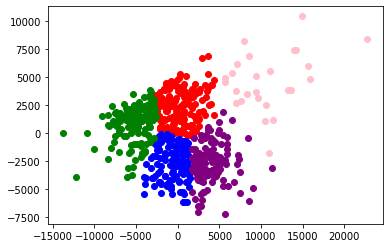

In [53]:
#Using first 2 principal components
component_1 = pca_df[:,0]
component_2 = pca_df[:, 1]
X = [[component_1[i], component_2[i]] for i in range(len(component_1))]
kmeans = KMeans(n_clusters=5).fit(X)
kmeans_df = pd.DataFrame({'component_1' : component_1, 'component_2' : component_2, 'cluster_assignment': kmeans.labels_})
plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == 0].iloc[:, 0] , kmeans_df.loc[kmeans_df.cluster_assignment == 0].iloc[:, 1] , color = 'red')
plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == 1].iloc[:, 0] , kmeans_df.loc[kmeans_df.cluster_assignment == 1].iloc[:, 1] , color = 'blue')
plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == 2].iloc[:, 0] , kmeans_df.loc[kmeans_df.cluster_assignment == 2].iloc[:, 1] , color = 'green')
plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == 3].iloc[:, 0] , kmeans_df.loc[kmeans_df.cluster_assignment == 3].iloc[:, 1] , color = 'pink')
plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == 4].iloc[:, 0] , kmeans_df.loc[kmeans_df.cluster_assignment == 4].iloc[:, 1] , color = 'purple')
plt.show()

In [41]:
kmeans_df.cluster_assignment.value_counts()

4    166
2    139
0    122
3    122
1     26
Name: cluster_assignment, dtype: int64

In [ ]:
# !pip install ipympl
# %matplotlib widget
f1_means = native_english_speakers['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f2_means = native_english_speakers['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f3_means = native_english_speakers['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
kmeans_3d = KMeans(n_clusters=5).fit(X)
temp_df = pd.DataFrame({'f1_means': f1_means, 'f2_means': f2_means, 'f3_means': f3_means, 'cluster': kmeans_3d.labels_})
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(temp_df.loc[temp_df.cluster == 0].iloc[:, 0], temp_df.loc[temp_df.cluster == 0].iloc[:, 1], temp_df.loc[temp_df.cluster == 0].iloc[:, 2], color = 'red')
ax.scatter(temp_df.loc[temp_df.cluster == 1].iloc[:, 0], temp_df.loc[temp_df.cluster == 1].iloc[:, 1], temp_df.loc[temp_df.cluster == 1].iloc[:, 2], color = 'blue')
ax.scatter(temp_df.loc[temp_df.cluster == 2].iloc[:, 0], temp_df.loc[temp_df.cluster == 2].iloc[:, 1], temp_df.loc[temp_df.cluster == 2].iloc[:, 2], color = 'green')
ax.scatter(temp_df.loc[temp_df.cluster == 3].iloc[:, 0], temp_df.loc[temp_df.cluster == 3].iloc[:, 1], temp_df.loc[temp_df.cluster == 3].iloc[:, 2], color = 'pink')
ax.scatter(temp_df.loc[temp_df.cluster == 4].iloc[:, 0], temp_df.loc[temp_df.cluster == 4].iloc[:, 1], temp_df.loc[temp_df.cluster == 4].iloc[:, 2], color = 'purple')
ax.set_xlabel('F1')
ax.set_xlabel('F2')
ax.set_xlabel('F3')
plt.show()
display(fig)

In [ ]:
temp_df.cluster.value_counts()

# GHMM - Dong


In [42]:
comp_1 = pca_df[:,0]
comp_2 = pca_df[:,1]
pca_com_12 = [[comp_1[i], comp_2[i]] for i in range(len(component_1))]

In [48]:
# how many clusters do we want to be dtermined later
# focusing on f1, f2, f3 I am assuming but right now using the f1 and f2 to get used of using the HMM
clusters = 12
model = hmm.GaussianHMM(n_components= clusters)
PCA_HMM = model.fit(pca_com_12)
hidden_states = PCA_HMM.predict(pca_com_12)


In [54]:
# still need to graph this :P
model2 = hmm.GaussianHMM(n_components= clusters)
X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
mean_HMM = model2.fit(X)
states = mean_HMM.predict(X)

NameError: ignored

In [50]:
HMM_df = pd.DataFrame({'component_1' : comp_1, 'component_2' : comp_2, 'cluster_assignment': hidden_states})
HMM_df.cluster_assignment.value_counts()

10    97
5     82
7     71
3     57
0     53
4     46
6     46
9     46
11    28
8     26
1     15
2      8
Name: cluster_assignment, dtype: int64

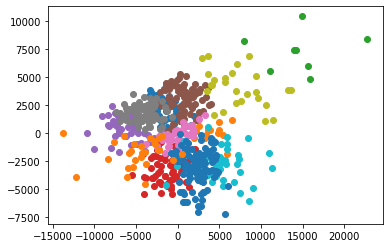

In [51]:
colors = ['r', 'g', 'b', 'k', 'y']
for  i in range(clusters):
  plt.scatter(HMM_df.loc[HMM_df.cluster_assignment == i].iloc[:, 0] , HMM_df.loc[HMM_df.cluster_assignment == i].iloc[:, 1])

In [52]:
#HMM3D_df = pd.DataFrame({'f1' : mean_data.f1.values.tolist(), 'f2' : mean_data.f2.values.tolist(), 'f3' : mean_data.f2.values.tolist(), 'cluster': states})
HMM3D_df = pd.DataFrame({'f1' : f1_means, 'f2' : f2_means, 'f3' : f3_means, 'cluster': states})
fig2 = plt.figure()
kx = fig2.add_subplot(projection='3d')
for i in range(clusters):
  kx.scatter(HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 0], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 1], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 2])
plt.show()
display(fig2)

NameError: ignored

In [ ]:
HMM3D_df.cluster.value_counts()